# A/B Testing Simulation (Market-Level)

In [1]:
# Libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set float display to avoid scientific notation
pd.set_option('display.float_format', '{:.2f}'.format)

# Wranings 
import warnings
warnings.filterwarnings('ignore')


StatementMeta(, 8e1c9120-9c55-41a8-8b54-356d60fa390d, 3, Finished, Available, Finished)

In [2]:
# Read data 
df = pd.read_parquet ("/lakehouse/default/Files/AB_data/market_level_elasticity/staged_df.parquet")

df.head()

StatementMeta(, 8e1c9120-9c55-41a8-8b54-356d60fa390d, 4, Finished, Available, Finished)

,pickup_datetime,trip_miles,trip_time,base_passenger_fare,is_airport,is_peak,is_weekend,distance_segment,time_segment
0,2025-01-04 14:57:17,4.50,33.60,31.33,0,1,1,urban3-6,long 85-99%
1,2025-01-04 14:21:39,2.39,12.97,13.38,0,1,1,short≤3,short ≤50%
2,2025-01-04 14:06:35,3.84,8.37,13.41,0,1,1,urban3-6,short ≤50%
3,2025-01-04 14:07:17,4.12,13.20,16.06,0,1,1,urban3-6,short ≤50%
4,2025-01-04 14:20:37,25.18,51.23,93.14,1,1,1,airport/suburban11-26,long 85-99%


### Split data
into Control and Treatment

In [3]:
# Split data 
np.random.seed(42) 

# 50:50 split 
df['group'] = np.where(np.random.rand(len(df)) < 0.5, 'control', 'treatment')
df.group.value_counts(normalize=True)               # Value counts

StatementMeta(, 8e1c9120-9c55-41a8-8b54-356d60fa390d, 5, Finished, Available, Finished)

group
treatment   0.50
control     0.50
Name: proportion, dtype: float64

In [4]:
# Head 
df.head()

StatementMeta(, 8e1c9120-9c55-41a8-8b54-356d60fa390d, 6, Finished, Available, Finished)

,pickup_datetime,trip_miles,trip_time,base_passenger_fare,is_airport,is_peak,is_weekend,distance_segment,time_segment,group
0,2025-01-04 14:57:17,4.50,33.60,31.33,0,1,1,urban3-6,long 85-99%,control
1,2025-01-04 14:21:39,2.39,12.97,13.38,0,1,1,short≤3,short ≤50%,treatment
2,2025-01-04 14:06:35,3.84,8.37,13.41,0,1,1,urban3-6,short ≤50%,treatment
3,2025-01-04 14:07:17,4.12,13.20,16.06,0,1,1,urban3-6,short ≤50%,treatment
4,2025-01-04 14:20:37,25.18,51.23,93.14,1,1,1,airport/suburban11-26,long 85-99%,control


In [5]:
# Describe control
df[df['group'] == 'control'].select_dtypes('float64').describe()

StatementMeta(, 8e1c9120-9c55-41a8-8b54-356d60fa390d, 7, Finished, Available, Finished)

,trip_miles,trip_time,base_passenger_fare
count,253760.00,253760.00,253760.00
mean,4.85,18.22,24.28
std,5.72,12.52,21.23
min,0.00,0.05,-10.82
25%,1.47,9.35,11.64
50%,2.83,15.02,17.98
75%,6.04,23.57,28.95
max,218.20,423.53,1210.97


In [6]:
# Describe treatment
df[df['group'] == 'treatment'].select_dtypes('float64').describe()

StatementMeta(, 8e1c9120-9c55-41a8-8b54-356d60fa390d, 8, Finished, Available, Finished)

,trip_miles,trip_time,base_passenger_fare
count,254541.00,254541.00,254541.00
mean,4.85,18.22,24.28
std,5.68,12.44,20.83
min,0.00,0.02,-5.67
25%,1.48,9.38,11.65
50%,2.83,15.07,18.05
75%,6.05,23.57,28.95
max,141.80,202.10,520.50


## Experimental fare

🎯 **Objective**

Does surge pricing (treatment) causes a lower acceptance rate compared to the control group? 

1. **Null hypothesis (H₀)**

Surge pricing does not change rider acceptance.
Formally:

𝑃(accept ∣ treatment) = 𝑃(accept ∣ control)


2. **Alternate hypothesis (H₁**)

Surge pricing reduces rider acceptance.
Formally:

𝑃(accept ∣ treatment) < 𝑃(accept ∣ control)


In [7]:
# Set surge
surge_multiplier = 1.2  # 20% surge

df['fare_exp'] = np.where(
    df['group'] == 'treatment',
    df['base_passenger_fare'] * surge_multiplier,       # treatment gets surge
    df['base_passenger_fare']                           # control gets no sure
)

df.head()                           # head

StatementMeta(, 8e1c9120-9c55-41a8-8b54-356d60fa390d, 9, Finished, Available, Finished)

,pickup_datetime,trip_miles,trip_time,base_passenger_fare,is_airport,is_peak,is_weekend,distance_segment,time_segment,group,fare_exp
0,2025-01-04 14:57:17,4.50,33.60,31.33,0,1,1,urban3-6,long 85-99%,control,31.33
1,2025-01-04 14:21:39,2.39,12.97,13.38,0,1,1,short≤3,short ≤50%,treatment,16.06
2,2025-01-04 14:06:35,3.84,8.37,13.41,0,1,1,urban3-6,short ≤50%,treatment,16.09
3,2025-01-04 14:07:17,4.12,13.20,16.06,0,1,1,urban3-6,short ≤50%,treatment,19.27
4,2025-01-04 14:20:37,25.18,51.23,93.14,1,1,1,airport/suburban11-26,long 85-99%,control,93.14


## Simulate rider acceptance

To compute acceptance rate and revenue, we need to assume a probability of acceptance that depends on fare.

A common starting point is a logistic demand model:

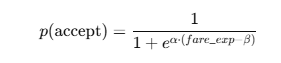

β (beta): midpoint fare (fare where acceptance = 50%).

α (alpha): slope (price sensitivity).

We can pick some illustrative parameters (say, α = 0.05, β = 15) or calibrate them from historical data.

Then for each request:

Compute p_accept from logistic.

Draw accepted ~ Bernoulli(p_accept).

Compute revenue = fare_exp * accepted.



In [8]:
df['base_passenger_fare'].median()

StatementMeta(, 8e1c9120-9c55-41a8-8b54-356d60fa390d, 10, Finished, Available, Finished)

18.02

#### Why alpha = 0.05 

In the logistic form we’ve been using

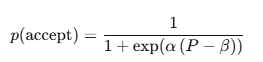

an α > 0 controls how steeply acceptance falls when price 
𝑃
P rises above the midpoint 
𝛽
β.

α has units of per-dollar (1 / currency). Larger α → much steeper drop for the same dollar increase.

0.05 is a modest slope: a few-dollar increase around the median produces a visible but not extreme drop in acceptance. That’s why it’s a convenient starting example.


In [9]:
# Example parameters (to be calibrated later)
alpha = 0.05   # price sensitivity / slope
beta = df['base_passenger_fare'].median()      # midpoint fare

# Compute acceptance probability for each request
df['p_accept'] = 1 / (1 + np.exp(alpha * (df['fare_exp'] - beta)))

# Simulate actual acceptance as 0/1
np.random.seed(42)
df['accepted'] = np.random.binomial(1, df['p_accept'])

# Compute revenue
df['revenue'] = df['fare_exp'] * df['accepted']

StatementMeta(, 8e1c9120-9c55-41a8-8b54-356d60fa390d, 11, Finished, Available, Finished)

In [10]:
# Summarize results

results = df.groupby("group").agg(
    acceptance_rate = ("accepted", "mean"),
    avg_fare = ("fare_exp", "mean"),
    avg_revenue = ("revenue", "mean"),
    sample_size = ("accepted", "count")
).reset_index()

print(results)

StatementMeta(, 8e1c9120-9c55-41a8-8b54-356d60fa390d, 12, Finished, Available, Finished)

       group  acceptance_rate  avg_fare  avg_revenue  sample_size
0    control             0.50     24.28         5.97       253760
1  treatment             0.43     29.13        11.42       254541


#### Z-Test (acceptance)

In [11]:
# sum accepted, count obs#

successes = df.groupby('group')['accepted'].sum()
nobs = df.groupby('group')['accepted'].count()

print ("Succeses: ", successes)
print ("\nObeservations#: ", nobs)

StatementMeta(, 8e1c9120-9c55-41a8-8b54-356d60fa390d, 13, Finished, Available, Finished)

Succeses:  group
control      127125
treatment    108461
Name: accepted, dtype: int64

Obeservations#:  group
control      253760
treatment    254541
Name: accepted, dtype: int64


In [12]:
# Order = treatment 1st, control 2nd
order = ['treatment', 'control']
successes = successes.reindex(order)
nobs = nobs.reindex(order)

print ("Successes: ", successes)
print ("\nObservations: ", nobs)

StatementMeta(, 8e1c9120-9c55-41a8-8b54-356d60fa390d, 14, Finished, Available, Finished)

Successes:  group
treatment    108461
control      127125
Name: accepted, dtype: int64

Observations:  group
treatment    254541
control      253760
Name: accepted, dtype: int64


In [13]:
from statsmodels.stats.proportion import proportions_ztest

zstat, pval = proportions_ztest(successes, nobs, alternative='smaller')
print (f"Acceptance rate test: z={zstat: 3f}, p={pval: 4f}")

StatementMeta(, 8e1c9120-9c55-41a8-8b54-356d60fa390d, 15, Finished, Available, Finished)

Acceptance rate test: z=-53.515389, p= 0.000000


T-Test (of Revenue)

In [14]:
# View df
cols = ['group', 'base_passenger_fare', 'fare_exp', 'p_accept', 'accepted', 'revenue']
df[cols].head(15)

StatementMeta(, 8e1c9120-9c55-41a8-8b54-356d60fa390d, 16, Finished, Available, Finished)

,group,base_passenger_fare,fare_exp,p_accept,accepted,revenue
0,control,31.33,31.33,0.34,0,0.00
1,treatment,13.38,16.06,0.52,0,0.00
2,treatment,13.41,16.09,0.52,0,0.00
3,treatment,16.06,19.27,0.48,1,19.27
4,control,93.14,93.14,0.02,0,0.00
5,control,18.23,18.23,0.50,0,0.00
6,control,36.42,36.42,0.28,0,0.00
7,treatment,6.38,7.66,0.63,0,0.00
8,treatment,16.78,20.14,0.47,1,20.14
9,treatment,31.41,37.69,0.27,0,0.00


In [15]:
# Mean rev by groups
df.groupby('group')['revenue'].mean()

StatementMeta(, 8e1c9120-9c55-41a8-8b54-356d60fa390d, 17, Finished, Available, Finished)

group
control      5.97
treatment   11.42
Name: revenue, dtype: float64

**Note**: revenue in treatment is roughly 91% over revenue in control

#### T-Test (revenue)

In [16]:
from scipy.stats import ttest_ind

StatementMeta(, 8e1c9120-9c55-41a8-8b54-356d60fa390d, 18, Finished, Available, Finished)

In [17]:
# T-Test Revenue
control_rev = df.loc[df.group=="control", "revenue"]
treatment_rev = df.loc[df.group=="treatment", "revenue"]
tstat, pval_rev = ttest_ind(control_rev, treatment_rev)

print(f"Revenue test: t={tstat:.3f}, p={pval_rev:.4f}")

StatementMeta(, 8e1c9120-9c55-41a8-8b54-356d60fa390d, 19, Finished, Available, Finished)

Revenue test: t=-165.719, p=0.0000


In [18]:
df.columns

StatementMeta(, 8e1c9120-9c55-41a8-8b54-356d60fa390d, 20, Finished, Available, Finished)

Index(['pickup_datetime', 'trip_miles', 'trip_time', 'base_passenger_fare',
       'is_airport', 'is_peak', 'is_weekend', 'distance_segment',
       'time_segment', 'group', 'fare_exp', 'p_accept', 'accepted', 'revenue'],
      dtype='object')

## Elasticity

### All-up Market

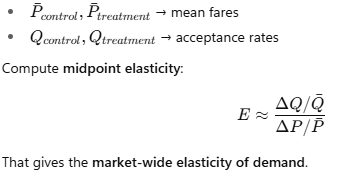

In [19]:
# mean acceptance, fare 
summary = (
    df.groupby('group')
      .agg(
          mean_accepted=('accepted', 'mean'),     # average accepted
          mean_fare_base=('base_passenger_fare','mean'),
          mean_fare_exp=('fare_exp', 'mean'),       # means of experimental fare (only treatment)
          mean_revenue=('revenue', 'mean'),    # means of revenue per request
          n_obs=('p_accept', 'size')            # count of rides
      )
      .reset_index()
)

print("Summary Stats:\n" , summary, "\n")

StatementMeta(, 8e1c9120-9c55-41a8-8b54-356d60fa390d, 21, Finished, Available, Finished)

Summary Stats:
        group  mean_accepted  mean_fare_base  mean_fare_exp  mean_revenue  \
0    control           0.50           24.28          24.28          5.97   
1  treatment           0.43           24.28          29.13         11.42   

    n_obs  
0  253760  
1  254541   



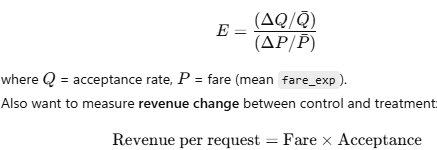

In [20]:
# Extract control and treatment rows
control = summary.loc[summary['group'] == "control"].iloc[0]
treatment = summary.loc[summary['group'] == "treatment"].iloc[0]

# Compute midpoint (arc) elasticity
delta_accept = treatment['mean_accepted'] - control['mean_accepted']
delta_fare   = float(treatment['mean_fare_exp'] - control['mean_fare_exp'])

avg_accept = float((treatment['mean_accepted'] + control['mean_accepted']) / 2)
avg_fare   = float((treatment['mean_fare_exp']   + control['mean_fare_exp']) / 2)

elasticity = (delta_accept / avg_accept) / (delta_fare / avg_fare)

# Revenue difference
rev_diff = float(treatment['mean_revenue'] - control['mean_revenue'])

StatementMeta(, 8e1c9120-9c55-41a8-8b54-356d60fa390d, 22, Finished, Available, Finished)

In [21]:
# Acceptance rates?
acceptance_rate = df.groupby('group')['accepted'].mean() 
print ("Rider Acceptance rates: \n", acceptance_rate.map("{:.4f}".format), "\n")

# mean Rev with base fares
df['rev_base_fare'] = df['base_passenger_fare'] * df['accepted']
print ("Mean rev with base fares: \n", df.groupby('group')[
        'rev_base_fare'].mean().map("{:.4f}".format), "\n")
# mean Rev with surged fares
print ("Mean Rev with surged fares: \n", df.groupby('group')[
        'revenue'].mean().map("{:.4f}".format), "\n")
        
# Acceptance Differences
print (f"Acceptance Differences: ")
print (f"Absolute Difference: {delta_accept:.4f}")
print (f"Relative difference: {delta_accept / control['mean_accepted']:.4%} \n")

# Base fare differences 
print (f"Base fare difference: ")
delta_base_fare = df.rev_base_fare[df['group'] == 'treatment'].mean() - \
    df.rev_base_fare[df['group'] == 'control'].mean()
print (f"Absolute Difference: {delta_base_fare:.4f}")
print (
f"Relative difference: {delta_base_fare / df.rev_base_fare[df['group'] == 'control'].mean():.4%} \n")

# Mean Rev with surged fare differences 
print (f"Surge fare differences: ")
delta_surged_fare = df.revenue[df['group'] == 'treatment'].mean() - \
                    df.revenue[df['group'] == 'control'].mean()
print (f"Absolute Difference: {delta_surged_fare:.4f}")
print (
f"Relative Difference: {delta_surged_fare / df.revenue[df['group'] == 'control'].mean():.4%} \n")

# Elasticity
print(f"Elasticity (arc method): {elasticity:.4f}")

StatementMeta(, 8e1c9120-9c55-41a8-8b54-356d60fa390d, 23, Finished, Available, Finished)

Rider Acceptance rates: 
 group
control      0.5010
treatment    0.4261
Name: accepted, dtype: object 

Mean rev with base fares: 
 group
control      5.9731
treatment    9.5152
Name: rev_base_fare, dtype: object 

Mean Rev with surged fares: 
 group
control       5.9731
treatment    11.4182
Name: revenue, dtype: object 

Acceptance Differences: 
Absolute Difference: -0.0749
Relative difference: -14.9434% 

Base fare difference: 
Absolute Difference: 3.5421
Relative difference: 59.3014% 

Surge fare differences: 
Absolute Difference: 5.4452
Relative Difference: 91.1617% 

Elasticity (arc method): -0.8878


## By Markets

### Airport Rides

In [22]:
# Summary Stats by Segment, group
seg_col = 'is_airport'   # can later replace with is_peak, is_weekend, etc.

summary_seg = (
    df.groupby([seg_col, 'group'])
      .agg(
          mean_accept=('p_accept', 'mean'),
          mean_fare=('fare_exp', 'mean'),
          mean_revenue=('revenue', 'mean'),
          n_obs=('p_accept', 'size')
      )
      .reset_index()
)

print ("Segment Summary:")
summary_seg

StatementMeta(, 8e1c9120-9c55-41a8-8b54-356d60fa390d, 24, Finished, Available, Finished)

Segment Summary:


,is_airport,group,mean_accept,mean_fare,mean_revenue,n_obs
0,0,control,0.47,21.42,6.41,234475
1,0,treatment,0.43,25.76,11.47,235257
2,1,control,0.18,59.04,0.61,19285
3,1,treatment,0.14,70.29,10.84,19284


In [23]:
# Elasticity, summary stats by Segment, group
results = []

for seg_value in summary_seg[seg_col].unique():
    sub = summary_seg[summary_seg[seg_col] == seg_value].set_index('group')

    ac = float(sub.at['control', 'mean_accept'])   # control acceptance
    at = float(sub.at['treatment', 'mean_accept'])   # treatment acceptance
    fc = float(sub.at['control', 'mean_fare'])     # control fare
    ft = float(sub.at['treatment', 'mean_fare'])     # treatment fare
    rc = float(sub.at['control', 'mean_revenue'])  # control revenue
    rt = float(sub.at['treatment', 'mean_revenue'])  # treatment revenue

    delta_accept = at - ac
    delta_fare   = ft - fc
    avg_accept   = (at + ac) / 2
    avg_fare     = (ft + fc) / 2

    elasticity = (delta_accept / avg_accept) / (delta_fare / avg_fare)
    rev_diff = rt - rc

    results.append({
        seg_col: seg_value,
        'elasticity': elasticity,
        'rev_diff': rev_diff,
        'accept_control': ac,
        'accept_treatment': at,
        'fare_control': fc,
        'fare_treatment': ft,
        'rev_control': rc,
        'rev_treatment': rt,
        'n_control': int(sub.at['control', 'n_obs']),
        'n_treatment': int(sub.at['treatment', 'n_obs'])
    })

# Results to new df 
results_df = pd.DataFrame(results)
results_df

StatementMeta(, 8e1c9120-9c55-41a8-8b54-356d60fa390d, 25, Finished, Available, Finished)

,is_airport,elasticity,rev_diff,accept_control,accept_treatment,fare_control,fare_treatment,rev_control,rev_treatment,n_control,n_treatment
0,0,-0.51,5.05,0.47,0.43,21.42,25.76,6.41,11.47,234475,235257
1,1,-1.51,10.23,0.18,0.14,59.04,70.29,0.61,10.84,19285,19284


In [24]:
# Pivot table
results_df.pivot_table(values=['elasticity', 'rev_diff', 'accept_control',
       'accept_treatment', 'fare_control', 'fare_treatment', 'rev_control',
       'rev_treatment', 'n_control', 'n_treatment'], columns=['is_airport'], 
       aggfunc='first').reindex(['elasticity', 'rev_diff', 'accept_control',
       'accept_treatment', 'fare_control', 'fare_treatment', 'rev_control',
       'rev_treatment', 'n_control', 'n_treatment'])

StatementMeta(, 8e1c9120-9c55-41a8-8b54-356d60fa390d, 26, Finished, Available, Finished)

is_airport,0,1
elasticity,-0.51,-1.51
rev_diff,5.05,10.23
accept_control,0.47,0.18
accept_treatment,0.43,0.14
fare_control,21.42,59.04
fare_treatment,25.76,70.29
rev_control,6.41,0.61
rev_treatment,11.47,10.84
n_control,234475.00,19285.00
n_treatment,235257.00,19284.00


### Peak Hours

In [25]:
df.columns

StatementMeta(, 8e1c9120-9c55-41a8-8b54-356d60fa390d, 27, Finished, Available, Finished)

Index(['pickup_datetime', 'trip_miles', 'trip_time', 'base_passenger_fare',
       'is_airport', 'is_peak', 'is_weekend', 'distance_segment',
       'time_segment', 'group', 'fare_exp', 'p_accept', 'accepted', 'revenue',
       'rev_base_fare'],
      dtype='object')

In [26]:
# Summary Stats by Segment, group
seg_col = 'is_peak'   # can later replace with is_peak, is_weekend, etc.

summary_seg = (
    df.groupby([seg_col, 'group'])
      .agg(
          mean_accept=('p_accept', 'mean'),
          mean_fare=('fare_exp', 'mean'),
          mean_revenue=('revenue', 'mean'),
          n_obs=('p_accept', 'size')
      )
      .reset_index()
)

print ("Segment Summary:")
summary_seg

StatementMeta(, 8e1c9120-9c55-41a8-8b54-356d60fa390d, 28, Finished, Available, Finished)

Segment Summary:


,is_peak,group,mean_accept,mean_fare,mean_revenue,n_obs
0,0,control,0.45,24.75,5.75,92746
1,0,treatment,0.40,29.75,11.59,92639
2,1,control,0.46,24.00,6.10,161014
3,1,treatment,0.41,28.78,11.32,161902


In [27]:
# Elasticity, summary stats by Segment, group
results = []

for seg_value in summary_seg[seg_col].unique():
    sub = summary_seg[summary_seg[seg_col] == seg_value].set_index('group')

    ac = float(sub.at['control', 'mean_accept'])   # control acceptance
    at = float(sub.at['treatment', 'mean_accept'])   # treatment acceptance
    fc = float(sub.at['control', 'mean_fare'])     # control fare
    ft = float(sub.at['treatment', 'mean_fare'])     # treatment fare
    rc = float(sub.at['control', 'mean_revenue'])  # control revenue
    rt = float(sub.at['treatment', 'mean_revenue'])  # treatment revenue

    delta_accept = at - ac
    delta_fare   = ft - fc
    avg_accept   = (at + ac) / 2
    avg_fare     = (ft + fc) / 2

    elasticity = (delta_accept / avg_accept) / (delta_fare / avg_fare)
    rev_diff = rt - rc

    results.append({
        seg_col: seg_value,
        'elasticity': elasticity,
        'rev_diff': rev_diff,
        'accept_control': ac,
        'accept_treatment': at,
        'fare_control': fc,
        'fare_treatment': ft,
        'rev_control': rc,
        'rev_treatment': rt,
        'n_control': int(sub.at['control', 'n_obs']),
        'n_treatment': int(sub.at['treatment', 'n_obs'])
    })

# Results to new df 
results_df = pd.DataFrame(results)
results_df

StatementMeta(, 8e1c9120-9c55-41a8-8b54-356d60fa390d, 29, Finished, Available, Finished)

,is_peak,elasticity,rev_diff,accept_control,accept_treatment,fare_control,fare_treatment,rev_control,rev_treatment,n_control,n_treatment
0,0,-0.55,5.84,0.45,0.40,24.75,29.75,5.75,11.59,92746,92639
1,1,-0.54,5.22,0.46,0.41,24.00,28.78,6.10,11.32,161014,161902


In [28]:
# Pivot table
results_df.pivot_table(values=['elasticity', 'rev_diff', 'accept_control',
       'accept_treatment', 'fare_control', 'fare_treatment', 'rev_control',
       'rev_treatment', 'n_control', 'n_treatment'], columns=['is_peak'], 
       aggfunc='first').reindex(['elasticity', 'rev_diff', 'accept_control',
       'accept_treatment', 'fare_control', 'fare_treatment', 'rev_control',
       'rev_treatment', 'n_control', 'n_treatment'])

StatementMeta(, 8e1c9120-9c55-41a8-8b54-356d60fa390d, 30, Finished, Available, Finished)

is_peak,0,1
elasticity,-0.55,-0.54
rev_diff,5.84,5.22
accept_control,0.45,0.46
accept_treatment,0.40,0.41
fare_control,24.75,24.00
fare_treatment,29.75,28.78
rev_control,5.75,6.10
rev_treatment,11.59,11.32
n_control,92746.00,161014.00
n_treatment,92639.00,161902.00


### Weekend Rides

In [29]:
# Summary Stats by Segment, group
seg_col = 'is_weekend'   # can later replace with is_peak, is_weekend, etc.

summary_seg = (
    df.groupby([seg_col, 'group'])
      .agg(
          mean_accept=('p_accept', 'mean'),
          mean_fare=('fare_exp', 'mean'),
          mean_revenue=('revenue', 'mean'),
          n_obs=('p_accept', 'size')
      )
      .reset_index()
)

print ("Segment Summary:")
summary_seg

StatementMeta(, 8e1c9120-9c55-41a8-8b54-356d60fa390d, 31, Finished, Available, Finished)

Segment Summary:


,is_weekend,group,mean_accept,mean_fare,mean_revenue,n_obs
0,0,control,0.45,24.77,5.92,185005
1,0,treatment,0.41,29.77,11.37,185555
2,1,control,0.46,22.95,6.11,68755
3,1,treatment,0.42,27.41,11.54,68986


In [30]:
# Elasticity, summary stats by Segment, group
results = []

for seg_value in summary_seg[seg_col].unique():
    sub = summary_seg[summary_seg[seg_col] == seg_value].set_index('group')

    ac = float(sub.at['control', 'mean_accept'])   # control acceptance
    at = float(sub.at['treatment', 'mean_accept'])   # treatment acceptance
    fc = float(sub.at['control', 'mean_fare'])     # control fare
    ft = float(sub.at['treatment', 'mean_fare'])     # treatment fare
    rc = float(sub.at['control', 'mean_revenue'])  # control revenue
    rt = float(sub.at['treatment', 'mean_revenue'])  # treatment revenue

    delta_accept = at - ac
    delta_fare   = ft - fc
    avg_accept   = (at + ac) / 2
    avg_fare     = (ft + fc) / 2

    elasticity = (delta_accept / avg_accept) / (delta_fare / avg_fare)
    rev_diff = rt - rc

    results.append({
        seg_col: seg_value,
        'elasticity': elasticity,
        'rev_diff': rev_diff,
        'accept_control': ac,
        'accept_treatment': at,
        'fare_control': fc,
        'fare_treatment': ft,
        'rev_control': rc,
        'rev_treatment': rt,
        'n_control': int(sub.at['control', 'n_obs']),
        'n_treatment': int(sub.at['treatment', 'n_obs'])
    })

# Results to new df 
results_df = pd.DataFrame(results)
results_df

StatementMeta(, 8e1c9120-9c55-41a8-8b54-356d60fa390d, 32, Finished, Available, Finished)

,is_weekend,elasticity,rev_diff,accept_control,accept_treatment,fare_control,fare_treatment,rev_control,rev_treatment,n_control,n_treatment
0,0,-0.55,5.45,0.45,0.41,24.77,29.77,5.92,11.37,185005,185555
1,1,-0.53,5.43,0.46,0.42,22.95,27.41,6.11,11.54,68755,68986


In [31]:
# Pivot table
results_df.pivot_table(values=['elasticity', 'rev_diff', 'accept_control',
       'accept_treatment', 'fare_control', 'fare_treatment', 'rev_control',
       'rev_treatment', 'n_control', 'n_treatment'], columns=['is_weekend'], 
       aggfunc='first').reindex(['elasticity', 'rev_diff', 'accept_control',
       'accept_treatment', 'fare_control', 'fare_treatment', 'rev_control',
       'rev_treatment', 'n_control', 'n_treatment'])

StatementMeta(, 8e1c9120-9c55-41a8-8b54-356d60fa390d, 33, Finished, Available, Finished)

is_weekend,0,1
elasticity,-0.55,-0.53
rev_diff,5.45,5.43
accept_control,0.45,0.46
accept_treatment,0.41,0.42
fare_control,24.77,22.95
fare_treatment,29.77,27.41
rev_control,5.92,6.11
rev_treatment,11.37,11.54
n_control,185005.00,68755.00
n_treatment,185555.00,68986.00


### Distance Segments

In [32]:
# Summary Stats by Segment, group
seg_col = 'distance_segment'   # can later replace with is_peak, is_weekend, etc.

summary_seg = (
    df.groupby([seg_col, 'group'])
      .agg(
          mean_accept=('p_accept', 'mean'),
          mean_fare=('fare_exp', 'mean'),
          mean_revenue=('revenue', 'mean'),
          n_obs=('p_accept', 'size')
      )
      .reset_index()
)

print ("Segment Summary:")
summary_seg

StatementMeta(, 8e1c9120-9c55-41a8-8b54-356d60fa390d, 34, Finished, Available, Finished)

Segment Summary:


,distance_segment,group,mean_accept,mean_fare,mean_revenue,n_obs
0,airport/suburban11-26,control,0.16,57.86,0.05,23486
1,airport/suburban11-26,treatment,0.12,69.70,11.31,23591
2,ext urban6-11,control,0.32,34.72,0.66,37664
3,ext urban6-11,treatment,0.26,41.44,18.05,37888
4,short≤3,control,0.56,13.59,9.57,132351
5,short≤3,treatment,0.52,16.38,6.88,132723
6,urban3-6,control,0.44,23.60,3.88,57578
7,urban3-6,treatment,0.38,28.37,17.99,57700
8,very_long>26,control,0.02,125.32,0.00,2681
9,very_long>26,treatment,0.01,148.22,1.83,2639


In [33]:
# Elasticity, summary stats by Segment, group
results = []

for seg_value in summary_seg[seg_col].unique():
    sub = summary_seg[summary_seg[seg_col] == seg_value].set_index('group')

    ac = float(sub.at['control', 'mean_accept'])   # control acceptance
    at = float(sub.at['treatment', 'mean_accept'])   # treatment acceptance
    fc = float(sub.at['control', 'mean_fare'])     # control fare
    ft = float(sub.at['treatment', 'mean_fare'])     # treatment fare
    rc = float(sub.at['control', 'mean_revenue'])  # control revenue
    rt = float(sub.at['treatment', 'mean_revenue'])  # treatment revenue

    delta_accept = at - ac
    delta_fare   = ft - fc
    avg_accept   = (at + ac) / 2
    avg_fare     = (ft + fc) / 2

    elasticity = (delta_accept / avg_accept) / (delta_fare / avg_fare)
    rev_diff = rt - rc

    results.append({
        seg_col: seg_value,
        'elasticity': elasticity,
        'rev_diff': rev_diff,
        'accept_control': ac,
        'accept_treatment': at,
        'fare_control': fc,
        'fare_treatment': ft,
        'rev_control': rc,
        'rev_treatment': rt,
        'n_control': int(sub.at['control', 'n_obs']),
        'n_treatment': int(sub.at['treatment', 'n_obs'])
    })

# Results to new df 
results_df = pd.DataFrame(results)
results_df

StatementMeta(, 8e1c9120-9c55-41a8-8b54-356d60fa390d, 35, Finished, Available, Finished)

,distance_segment,elasticity,rev_diff,accept_control,accept_treatment,fare_control,fare_treatment,rev_control,rev_treatment,n_control,n_treatment
0,airport/suburban11-26,-1.89,11.26,0.16,0.12,57.86,69.70,0.05,11.31,23486,23591
1,ext urban6-11,-1.14,17.39,0.32,0.26,34.72,41.44,0.66,18.05,37664,37888
2,short≤3,-0.33,-2.69,0.56,0.52,13.59,16.38,9.57,6.88,132351,132723
3,urban3-6,-0.70,14.10,0.44,0.38,23.60,28.37,3.88,17.99,57578,57700
4,very_long>26,-4.43,1.83,0.02,0.01,125.32,148.22,0.00,1.83,2681,2639


In [34]:
# Pivot table
results_df.pivot_table(values=['elasticity', 'rev_diff', 'accept_control',
       'accept_treatment', 'fare_control', 'fare_treatment', 'rev_control',
       'rev_treatment', 'n_control', 'n_treatment'], columns=['distance_segment'], 
       aggfunc='first').reindex(['elasticity', 'rev_diff', 'accept_control',
       'accept_treatment', 'fare_control', 'fare_treatment', 'rev_control',
       'rev_treatment', 'n_control', 'n_treatment'])

StatementMeta(, 8e1c9120-9c55-41a8-8b54-356d60fa390d, 36, Finished, Available, Finished)

distance_segment,airport/suburban11-26,ext urban6-11,short≤3,urban3-6,very_long>26
elasticity,-1.89,-1.14,-0.33,-0.70,-4.43
rev_diff,11.26,17.39,-2.69,14.10,1.83
accept_control,0.16,0.32,0.56,0.44,0.02
accept_treatment,0.12,0.26,0.52,0.38,0.01
fare_control,57.86,34.72,13.59,23.60,125.32
fare_treatment,69.70,41.44,16.38,28.37,148.22
rev_control,0.05,0.66,9.57,3.88,0.00
rev_treatment,11.31,18.05,6.88,17.99,1.83
n_control,23486.00,37664.00,132351.00,57578.00,2681.00
n_treatment,23591.00,37888.00,132723.00,57700.00,2639.00


### Time Segments

In [35]:
# Summary Stats by Segment, group
seg_col = 'time_segment'   # can later replace with is_peak, is_weekend, etc.

summary_seg = (
    df.groupby([seg_col, 'group'])
      .agg(
          mean_accept=('p_accept', 'mean'),
          mean_fare=('fare_exp', 'mean'),
          mean_revenue=('revenue', 'mean'),
          n_obs=('p_accept', 'size')
      )
      .reset_index()
)

print ("Segment Summary:")
summary_seg

StatementMeta(, 8e1c9120-9c55-41a8-8b54-356d60fa390d, 37, Finished, Available, Finished)

Segment Summary:


,time_segment,group,mean_accept,mean_fare,mean_revenue,n_obs
0,long 85-99%,control,0.21,51.66,0.30,35598
1,long 85-99%,treatment,0.16,61.97,13.29,35472
2,medium 50-85%,control,0.40,26.82,2.98,88388
3,medium 50-85%,treatment,0.35,32.27,17.85,89326
4,short ≤50%,control,0.56,13.16,9.76,127241
5,short ≤50%,treatment,0.53,15.83,6.53,127196
6,verylong >99%,control,0.06,108.70,0.04,2533
7,verylong >99%,treatment,0.03,126.46,3.86,2547


In [36]:
# Elasticity, summary stats by Segment, group
results = []

for seg_value in summary_seg[seg_col].unique():
    sub = summary_seg[summary_seg[seg_col] == seg_value].set_index('group')

    ac = float(sub.at['control', 'mean_accept'])   # control acceptance
    at = float(sub.at['treatment', 'mean_accept'])   # treatment acceptance
    fc = float(sub.at['control', 'mean_fare'])     # control fare
    ft = float(sub.at['treatment', 'mean_fare'])     # treatment fare
    rc = float(sub.at['control', 'mean_revenue'])  # control revenue
    rt = float(sub.at['treatment', 'mean_revenue'])  # treatment revenue

    delta_accept = at - ac
    delta_fare   = ft - fc
    avg_accept   = (at + ac) / 2
    avg_fare     = (ft + fc) / 2

    elasticity = (delta_accept / avg_accept) / (delta_fare / avg_fare)
    rev_diff = rt - rc

    results.append({
        seg_col: seg_value,
        'elasticity': elasticity,
        'rev_diff': rev_diff,
        'accept_control': ac,
        'accept_treatment': at,
        'fare_control': fc,
        'fare_treatment': ft,
        'rev_control': rc,
        'rev_treatment': rt,
        'n_control': int(sub.at['control', 'n_obs']),
        'n_treatment': int(sub.at['treatment', 'n_obs'])
    })

# Results to new df 
results_df = pd.DataFrame(results)
results_df

StatementMeta(, 8e1c9120-9c55-41a8-8b54-356d60fa390d, 38, Finished, Available, Finished)

,time_segment,elasticity,rev_diff,accept_control,accept_treatment,fare_control,fare_treatment,rev_control,rev_treatment,n_control,n_treatment
0,long 85-99%,-1.49,12.99,0.21,0.16,51.66,61.97,0.30,13.29,35598,35472
1,medium 50-85%,-0.79,14.87,0.40,0.35,26.82,32.27,2.98,17.85,88388,89326
2,short ≤50%,-0.32,-3.23,0.56,0.53,13.16,15.83,9.76,6.53,127241,127196
3,verylong >99%,-3.22,3.82,0.06,0.03,108.70,126.46,0.04,3.86,2533,2547


In [37]:
# Pivot table
results_df.pivot_table(values=['elasticity', 'rev_diff', 'accept_control',
       'accept_treatment', 'fare_control', 'fare_treatment', 'rev_control',
       'rev_treatment', 'n_control', 'n_treatment'], columns=['time_segment'], 
       aggfunc='first').reindex(['elasticity', 'rev_diff', 'accept_control',
       'accept_treatment', 'fare_control', 'fare_treatment', 'rev_control',
       'rev_treatment', 'n_control', 'n_treatment'])

StatementMeta(, 8e1c9120-9c55-41a8-8b54-356d60fa390d, 39, Finished, Available, Finished)

time_segment,long 85-99%,medium 50-85%,short ≤50%,verylong >99%
elasticity,-1.49,-0.79,-0.32,-3.22
rev_diff,12.99,14.87,-3.23,3.82
accept_control,0.21,0.40,0.56,0.06
accept_treatment,0.16,0.35,0.53,0.03
fare_control,51.66,26.82,13.16,108.70
fare_treatment,61.97,32.27,15.83,126.46
rev_control,0.30,2.98,9.76,0.04
rev_treatment,13.29,17.85,6.53,3.86
n_control,35598.00,88388.00,127241.00,2533.00
n_treatment,35472.00,89326.00,127196.00,2547.00
